In [1]:
#Import all libraries that are required
%matplotlib inline

import numpy as np
import pandas as pd
# pd.options.display.float_formatrmat = '${:,.2f}'.format
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from wordcloud import WordCloud

from io import BytesIO
from requests import get
from PIL import Image, ImageDraw
import instaloader
import pymongo

from pandas.io.json import json_normalize
import json

#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*
from itertools import dropwhile, takewhile
import collections
import requests
import base64

import nltk
from ast import literal_eval
from datetime import timedelta
import string
import statistics
import itertools

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import spacy
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
# from contractions import CONTRACTION_MAP
import unicodedata


from functools import reduce
import operator


import sys
sys.path.append('../')
import Variables as vr

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# create loader object
L = instaloader.Instaloader()
LIST_ALL_USERS = vr.LIST_ALL_USERS

nltk.download('stopwords')
nltk.download('punkt')


USE_LOCAL_DA = True

if (not USE_LOCAL_DA):
    
    # MongoDB Database
    instagramClient = pymongo.MongoClient('157.159.68.107:27017',username='koosha',password='1123581321',authSource='Instagram')
    instagram_db = instagramClient["Instagram"]
    instagram_col_post = instagram_db["Post_impersonator_h"]
    instagram_col_comment = instagram_db["Comment_impersonator_h"]
    instagram_col_like = instagram_db["Like_impersonator_h"]
    instagram_col_impersonator = instagram_db["Imp_impersonator_h"]

else:

    # MongoDB Database
    Local_instagramClient = pymongo.MongoClient('127.0.0.1:27017',authSource='Instagram')
    instagram_db = Local_instagramClient["Instagram"]
    instagram_col_post = instagram_db["Post_impersonator_h"]
    instagram_col_comment = instagram_db["Comment_impersonator_h"]
    instagram_col_like = instagram_db["Like_impersonator_h"]
    instagram_col_impersonator = instagram_db["Imp_impersonator_h"]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# https://github.com/cjhutto/vaderSentiment#citation-information

# Load impersonator posts

In [4]:
# impersonator
_limit = 10000
df_impersonator =  pd.DataFrame(list(instagram_col_impersonator.find({
            "$or":
            [
                {'similarity_username': { '$gt': 0.15 }},
                {'similarity_full_name': { '$gt': 0.15 }},
                {'similarity_biography': { '$gt': 0.15 }},
                {'similarity_photo' : True },
            ]    
    
}).limit(_limit) ))

df_impersonator.shape[0]

1894

In [5]:
# df_impersonator = pd.read_csv('Dataset/impersonator_list.csv')
# df_impersonator.shape[0]

In [6]:
# post
_limit = 10000
df_post =  pd.DataFrame(list(instagram_col_post.find({}).limit(_limit) ))
df_post.shape[0]

8997

In [7]:
# df_post = pd.read_csv('Dataset/post_data.csv')
# df_post.shape[0]

# get dataframes

In [8]:
# politician
df_post_trump = df_post.loc[( df_post['associated_username'] == vr.DONALD_TRUMP ) ] 
df_post_obama = df_post.loc[( df_post['associated_username'] == vr.BARACK_OBAMA ) ]
df_post_macron = df_post.loc[( df_post['associated_username'] == vr.EMMANUEL_MACRON ) ]
df_post_johnson = df_post.loc[( df_post['associated_username'] == vr.BORIS_JOHNSON ) ]
df_post_may = df_post.loc[( df_post['associated_username'] == vr.THERESA_MAY ) ]

# sport player
df_post_cristiano_ronalod = df_post.loc[( df_post['associated_username'] == vr.CRISTIANO_RONALDO ) ] 
df_post_leo_messi = df_post.loc[( df_post['associated_username'] == vr.LEOMESSI ) ]
df_post_roger_federer = df_post.loc[( df_post['associated_username'] == vr.ROGER_FEDERER ) ]
df_post_rafael_nadal = df_post.loc[( df_post['associated_username'] == vr.RAFAEL_NADAL ) ]
df_post_djokovic = df_post.loc[( df_post['associated_username'] == vr.NOVAK_DJOKOVIC ) ]

#singers
df_post_lady_gaga = df_post.loc[( df_post['associated_username'] == vr.LADY_GAGA )] 
df_post_beyonce = df_post.loc[( df_post['associated_username'] == vr.BEYONCE ) ] 
df_post_taylor_swift = df_post.loc[( df_post['associated_username'] == vr.TAYLOR_SWIFT ) ] 
df_post_adele = df_post.loc[( df_post['associated_username'] == vr.ADELE ) ] 
df_post_madonna = df_post.loc[( df_post['associated_username'] == vr.MADONNA ) ] 

In [9]:
list_all_usecases = [
    df_post_trump, df_post_obama, df_post_macron, df_post_johnson, df_post_may,
    df_post_cristiano_ronalod, df_post_leo_messi, df_post_rafael_nadal, df_post_roger_federer, df_post_djokovic,
    df_post_lady_gaga, df_post_beyonce, df_post_taylor_swift, df_post_adele, df_post_madonna,
]

# Dataframe - Communities

In [10]:
df_politician = pd.concat([df_post_trump, df_post_obama, df_post_macron, df_post_johnson, df_post_may])
df_sportplayer = pd.concat([df_post_cristiano_ronalod, df_post_leo_messi, df_post_rafael_nadal, df_post_roger_federer, df_post_djokovic])
df_musician = pd.concat([df_post_lady_gaga, df_post_beyonce, df_post_taylor_swift, df_post_adele, df_post_madonna])

df_politician['community'] = 'politician'
df_sportplayer['community'] = 'sportplayer'
df_musician['community'] = 'musician'


print("politician: " + str(df_politician.shape[0]))
print("sportplayer: " + str(df_sportplayer.shape[0]))
print("musician: " + str(df_musician.shape[0]))

politician: 1516
sportplayer: 2511
musician: 4865


In [11]:
df_all_post = pd.concat([df_politician, df_sportplayer, df_musician])
df_all_post.shape[0]

8892

In [12]:
df_post_politician = df_politician.dropna(subset=['post_caption'])
df_post_sportplayer = df_sportplayer.dropna(subset=['post_caption'])
df_post_musician = df_musician.dropna(subset=['post_caption'])

# Filter usercases

In [13]:
for item in vr.LIST_ALL_USERS:
    df_all_post = df_all_post[df_all_post['post_owner_username'] != item]

df_all_post.shape[0]

8892

In [14]:
for item in vr.LIST_ALL_USERS:
    df_impersonator = df_impersonator[df_impersonator['username'] != item]

df_impersonator.shape[0]

1894

In [15]:
def process_post(_row):

    if (_row['post_caption'] != None):
        _row['post_caption_len'] = len(_row['post_caption'])
    else:
        _row['post_caption_len'] = 0
        
    _row['post_caption_hashtags_len'] = len(_row['post_caption_hashtags'])
    
    _row['post_caption_mentions_len'] = len(_row['post_caption_mentions'])
    
    return _row

df_all_post = df_all_post.apply(process_post, axis=1)

In [16]:
df_impersonator.columns

Index(['_id', 'username', 'user_id', 'mediacount', 'followers', 'followees',
       'biography', 'full_name', 'is_verified', 'is_private', 'external_url',
       'profile_pic_url', 'profile_image', 'associated_hashtag',
       'associated_username', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similarity_photo', 'post', 'story',
       'highlight', 'relation_crawled', 'followee_list', 'follower_list'],
      dtype='object')

In [17]:
df_all_post.columns

Index(['_id', 'post_caption', 'post_date_utc', 'post_likes', 'post_comments',
       'post_shortcode', 'post_mediaid', 'post_url', 'post_thumbnail',
       'post_typename', 'post_caption_hashtags', 'post_caption_mentions',
       'post_is_video', 'post_video_url', 'post_viewer_has_liked',
       'post_location', 'post_tagged_users', 'associated_username',
       'associated_hashtag', 'post_owner_username', 'post_owner_id',
       'post_owner_mediacount', 'post_owner_followers', 'post_owner_followees',
       'post_owner_biography', 'post_owner_full_name',
       'post_owner_is_verified', 'post_owner_is_private',
       'post_owner_external_url', 'post_owner_profile_pic_url',
       'post_owner_similarity_username', 'post_owner_similarity_full_name',
       'post_owner_similarity_biography', 'post_owner_similarity_photo',
       'post_owener_external_url', 'post_owener_profile_pic_url',
       'post_associated_hashtag', 'post_associated_username', 'community',
       'post_caption_len',

In [18]:
def process_impersonator(_row):
    
    if (_row['external_url'] == None):
        _row['external_url_value'] = 0
    else:
        _row['external_url_value'] = 1
    
    
    return _row

df_impersonator = df_impersonator.apply(process_impersonator, axis=1)

In [19]:
avg_comment = []
avg_likes = []
avg_hashtag = []
avg_caption_length = []

list_name = []
list_comment = []
list_like = []
list_post_caption = []
list_community = []
list_hashtag = []


for name , group in df_all_post.groupby('post_owner_id'):
    list_name.append(name)
    
    avg_comment.append(group['post_comments'].mean())
    avg_likes.append(group['post_likes'].mean())
    avg_hashtag.append(group['post_caption_hashtags_len'].mean())
    avg_caption_length.append(group['post_caption_len'].mean())
    
    
    list_comment.append(group['post_comments'].tolist())
    list_like.append(group['post_likes'].tolist())
    list_post_caption.append(group['post_caption'].tolist())
    list_hashtag.append(group['post_caption_hashtags'].tolist())
    
    list_community.append(group['community'].tolist())

df_post_stats = pd.DataFrame()
df_post_stats['user_id'] = list_name
df_post_stats['avg comment'] = avg_comment
df_post_stats['avg like'] = avg_likes
df_post_stats['avg hashtag'] = avg_hashtag
df_post_stats['avg caption len'] = avg_caption_length

df_post_stats['comment'] = list_comment
df_post_stats['like'] = list_like
df_post_stats['caption'] = list_post_caption
df_post_stats['community'] = list_community
df_post_stats['hashtag'] = list_hashtag


print(df_post_stats.shape[0])
df_post_stats.head()

926


user_id  avg comment  avg like  avg hashtag  avg caption len  \
0   3502553         47.0    1532.5         1.75            60.75   
1   5139534          0.5      24.9         8.30           132.60   
2  11535357          2.4     190.8         4.50           135.00   
3  15564960         36.5     815.1         5.60           213.60   
4  17449911          3.5      18.1         4.50           159.80   

                                  comment  \
0                        [9, 60, 18, 101]   
1          [1, 0, 0, 2, 0, 0, 0, 0, 2, 0]   
2         [1, 4, 0, 10, 3, 0, 3, 3, 0, 0]   
3  [15, 0, 45, 25, 45, 111, 18, 9, 2, 95]   
4        [0, 4, 0, 0, 0, 2, 15, 2, 2, 10]   

                                                like  \
0                            [627, 1820, 1519, 2164]   
1           [23, 32, 25, 19, 17, 40, 16, 19, 30, 28]   
2       [78, 448, 67, 209, 58, 31, 67, 647, 205, 98]   
3  [235, 114, 991, 1650, 2163, 772, 529, 376, 151...   
4            [15, 11, 15, 6, 10, 14, 31, 26, 11, 42]   

                                             caption  \
0  [LA I’ll miss ya 🍂, You will always have a spe...   
1  [#RogerFederer @rogerfederer #RF #Federer #Sup...   
2  [Things I don’t have. This promo @ladygaga Sup...   
3  [Atendendo aos pedidos, próxima edição da FEST...   
4  [Thanksgiving 2019 🙏🏼🦃🌽\n#americanbulldogsofin...   

                                           community  \
0           [musician, musician, musician, musician]   
1  [sportplayer, sportplayer, sportplayer, sportp...   
2  [musician, musician, musician, musician, music...   
3  [musician, musician, musician, musician, music...   
4  [musician, musician, musician, musician, music...   

                                             hashtag  
0  [[], [hbdbritney, 2008, circus, bevelgamestron...  
1  [[rogerfederer, rf, federer, supporttheswiss, ...  
2  [[ladygaga, gagacollection, donthaveit], [joan...  
3  [[festonna, madonna, cher, mdna, madamex, mada...  
4  [[americanbulldogsofinstagram, hospers, iowa],...

# CLustering

In [20]:
df_dataset = df_impersonator
df_dataset.columns

Index(['_id', 'username', 'user_id', 'mediacount', 'followers', 'followees',
       'biography', 'full_name', 'is_verified', 'is_private', 'external_url',
       'profile_pic_url', 'profile_image', 'associated_hashtag',
       'associated_username', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similarity_photo', 'post', 'story',
       'highlight', 'relation_crawled', 'followee_list', 'follower_list',
       'external_url_value'],
      dtype='object')

In [21]:
# df_dataset = df_impersonator[[
    
#         'user_id',
    
#         'similarity_username', 
#         'similarity_full_name',
#         'similarity_biography',
#         'similarity_photo',

#         'followers',     
#         'followees',
#         'mediacount',
#         'is_private',
#         'is_verified', 

#    ]]
# #df_dataset.columns = ['id', 'sim_username', 'similarity_name', 'similarity_bio', 'similarity_photo', 'follower', 'followee', 'mediacount', 'private', 'verified']
# # df_dataset['class'] = 'impersonator'
# df_dataset[[ 'private', 'verified']] = df_dataset[['private', 'verified']].astype(int)
# df_dataset.head()

In [22]:
df_dataset.loc[df_dataset.similarity_photo == 'False'] = 0
df_dataset.loc[df_dataset.similarity_photo == 'True'] = 1
df_dataset['similarity_photo'] = df_dataset['similarity_photo'].astype(int)
# df_dataset['similarity_photo'].tolist()

In [23]:
def calculate_least_common_metrics(_row):

    _row['lcm'] = 0

    if (_row['similarity_username'] > 0):
        _row['lcm'] =  1
        return _row
    
    if (_row['similarity_full_name'] > 0):
        _row['lcm'] =  1
        return _row
    
    if (_row['similarity_biography'] > 0):
        _row['lcm'] =  1
        return _row
    
    if (_row['similarity_photo'] > 0):
        _row['lcm'] =  1
        return _row
        
    return _row

df_dataset = df_dataset.apply(calculate_least_common_metrics, axis=1)

In [24]:
def calculate_most_common_metrics(_row):

    _row['mcm'] = 0
    
    if (_row['similarity_username'] > 0):
        _row['mcm'] = _row['mcm'] + 1
    
    if (_row['similarity_full_name'] > 0):
        _row['mcm'] = _row['mcm'] + 1
    
    if (_row['similarity_biography'] > 0):
        _row['mcm'] = _row['mcm'] + 1
        
    if (_row['similarity_photo'] > 0):
        _row['mcm'] = _row['mcm'] + 1
        
    return _row

df_dataset = df_dataset.apply(calculate_most_common_metrics, axis=1)

# combine with post stats

In [25]:
df_merged = pd.merge(df_post_stats, df_dataset, on='user_id', how='outer')
df_merged = df_merged[df_merged['similarity_username'].isnull() == False]
# df_merged.shape[0]

# replace with zero
# df_merged['avg comment'].fillna(0, inplace=True)
# df_merged['avg like'].fillna(0, inplace=True)

# skipp nan
df_merged = df_merged[df_merged['avg comment'].isnull() == False]
df_merged = df_merged[df_merged['avg like'].isnull() == False]


df_merged.shape[0]

842

In [26]:
df_merged.columns

Index(['user_id', 'avg comment', 'avg like', 'avg hashtag', 'avg caption len',
       'comment', 'like', 'caption', 'community', 'hashtag', '_id', 'username',
       'mediacount', 'followers', 'followees', 'biography', 'full_name',
       'is_verified', 'is_private', 'external_url', 'profile_pic_url',
       'profile_image', 'associated_hashtag', 'associated_username',
       'similarity_username', 'similarity_full_name', 'similarity_biography',
       'similarity_photo', 'post', 'story', 'highlight', 'relation_crawled',
       'followee_list', 'follower_list', 'external_url_value', 'lcm', 'mcm'],
      dtype='object')

# normalize

In [27]:
# normalize 
column_names_to_normalize = ['followers']#, 'followee', 'mediacount']
x = df_merged[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_merged['nfollower'] = x_scaled

column_names_to_normalize = ['followees']#, 'followee', 'mediacount']
x = df_merged[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_merged['nfollowee'] = x_scaled


column_names_to_normalize = ['mediacount']#, 'followee', 'mediacount']
x = df_merged[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_merged['nmediacount'] = x_scaled


column_names_to_normalize = ['mcm']#, 'followee', 'mediacount']
x = df_merged[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_merged['nmcm'] = x_scaled

column_names_to_normalize = ['avg comment']#, 'followee', 'mediacount']
x = df_merged[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_merged['n avg comment'] = x_scaled

column_names_to_normalize = ['avg like']#, 'followee', 'mediacount']
x = df_merged[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_merged['n avg like'] = x_scaled

column_names_to_normalize = ['avg hashtag']
x = df_merged[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_merged['n avg hashtag'] = x_scaled

column_names_to_normalize = ['avg caption len']
x = df_merged[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_merged['n avg caption len'] = x_scaled

# select columns

In [28]:
df_merged.columns

Index(['user_id', 'avg comment', 'avg like', 'avg hashtag', 'avg caption len',
       'comment', 'like', 'caption', 'community', 'hashtag', '_id', 'username',
       'mediacount', 'followers', 'followees', 'biography', 'full_name',
       'is_verified', 'is_private', 'external_url', 'profile_pic_url',
       'profile_image', 'associated_hashtag', 'associated_username',
       'similarity_username', 'similarity_full_name', 'similarity_biography',
       'similarity_photo', 'post', 'story', 'highlight', 'relation_crawled',
       'followee_list', 'follower_list', 'external_url_value', 'lcm', 'mcm',
       'nfollower', 'nfollowee', 'nmediacount', 'nmcm', 'n avg comment',
       'n avg like', 'n avg hashtag', 'n avg caption len'],
      dtype='object')

# K-means

In [29]:
df_kmean = df_merged[['mcm', 'lcm',
                       'similarity_username', 'similarity_full_name', 'similarity_biography', 'similarity_photo',  
                       'nfollower', 'nfollowee', 'nmediacount',
                       'is_private', 'is_verified',
                      'n avg comment', 'n avg like', 'n avg hashtag', 'n avg caption len',
                        'external_url_value',
                      ]]

# 'similarity_full_name', 'similarity_username', 'similarity_biography', 'similarity_photo',
# 'lcm', 'mcm',
# 'is_private', 'is_verified',
# 'followers', 'followees', 'mediacount',
# 'nfollower', 'nfollowee', 'nmediacount',
# 'avg comment', 'avg like',
# 'n avg comment', 'n avg like', 'avg hashtag', 'avg caption len', 'n avg caption len',

In [30]:
# Split-out validation dataset
array = df_kmean.values
X = array[:,0:len(df_kmean.columns)-1]
Y = array[:,len(df_kmean.columns)-1]
validation_size = 0.30
seed = 10
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Optimum K

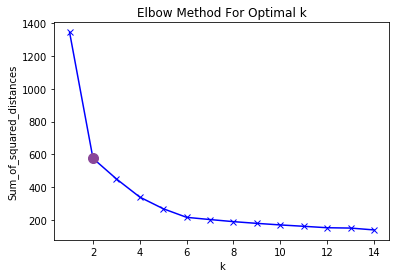

In [31]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plt.plot(2, Sum_of_squared_distances[1], c='#8a4799', alpha=1, ms=10,  marker='o')

plt.show()

In [32]:
# kmeans with optimum k
k = 3
km = KMeans(n_clusters=k)
km = km.fit(X)
df_merged['cluster'] = km.labels_
# save clusters to csv
df_merged.to_csv(r'Dataset/cluster_impersonator_3clusters.csv')
# df_merged.to_json(r'Dataset/cluster_impersonator_3clusters.json')

In [33]:
# kmeans with optimum k
k = 2
km = KMeans(n_clusters=k)
km = km.fit(X)
df_merged['cluster'] = km.labels_
# save clusters to csv
df_merged.to_csv(r'Dataset/cluster_impersonator_2clusters.csv')
# df_merged.to_json(r'Dataset/cluster_impersonator_2clusters.json')

# cluster Stats

In [34]:
grouped_clusters = df_merged.groupby('cluster')
cluster_0 = grouped_clusters.get_group(0)
cluster_1 = grouped_clusters.get_group(1)

In [35]:
t0 = cluster_0[['similarity_full_name', 'similarity_username', 'similarity_biography', 'similarity_photo', 
           'lcm', 'mcm', 
           'is_private', 'is_verified', 
           'followers', 'followees', 'mediacount',
           'nfollower', 'nfollowee', 'nmediacount',
           'avg comment', 'avg like', 
           'n avg comment', 'n avg like', 'avg hashtag', 'avg caption len', 'n avg caption len', 'external_url_value',
          ]].mean()

t1 = cluster_1[['similarity_full_name', 'similarity_username', 'similarity_biography', 'similarity_photo', 
           'lcm', 'mcm', 
           'is_private', 'is_verified', 
           'followers', 'followees', 'mediacount',
           'nfollower', 'nfollowee', 'nmediacount',
           'avg comment', 'avg like', 
           'n avg comment', 'n avg like', 'avg hashtag', 'avg caption len', 'n avg caption len', 'external_url_value',
          ]].mean()


df_cluster_mean = pd.DataFrame({"cluster 0": t0, "cluster 1": t1})
pd.options.display.float_format = '{:.5f}'.format
df_cluster_mean

cluster 0   cluster 1
similarity_full_name      0.13399     0.41360
similarity_username       0.18478     0.40170
similarity_biography      0.18153     0.25377
similarity_photo          0.16818     0.70896
lcm                       1.00000     1.00000
mcm                       1.53409     3.33085
is_private                0.00682     0.00000
is_verified               0.02273     0.01244
followers            101250.87727 18208.73881
followees               920.60682   729.06219
mediacount              673.32045   804.54478
nfollower                 0.00290     0.00052
nfollowee                 0.12268     0.09716
nmediacount               0.01700     0.02031
avg comment              24.95911    13.80319
avg like               1633.57307   861.61240
n avg comment             0.00487     0.00269
n avg like                0.00464     0.00244
avg hashtag              10.85708    10.79077
avg caption len         229.40478   230.13584
n avg caption len         0.12401     0.12440
external_url_value        0.33864     0.33085

In [36]:
cluster_0.shape[0]

440

In [37]:
cluster_1.shape[0]

402

In [38]:
cluster_0.shape[0] / df_merged.shape[0]

0.5225653206650831

In [39]:
cluster_1.shape[0] / df_merged.shape[0]

0.47743467933491684

In [49]:
cluster_1['username'].tolist()

['gagafrontrow',
 'madonnaonline',
 'rafaelnadalfans',
 'adam.adele',
 'rafaelnadalfc',
 'obama_is_the_antichrist1',
 'livxgaga',
 'theobamafamily44',
 'derek_4real_4real',
 'adelettes',
 'madonnaunderground',
 'cristianoronaldo_nr1',
 'messimaniacas',
 'ladygaganownet',
 'rafaelnadal__',
 'novakfanclub',
 'knewwehadourhandstied',
 'tayswiftmex',
 'ladygagalook',
 'gagatattooedgoddess',
 'lsvladygaga',
 '_djokovic',
 'onlygaga_',
 'imperio_messi',
 'teamtaylorswiftfin13',
 'tayswiftfact',
 '_messi_lover_forever_10_',
 'artedswiftie',
 'donaldtrump_2020',
 'federerworld',
 'cristiano7geo',
 'adeleslove',
 'we.are.messi',
 'legendofgagas',
 'd10s.leomessi',
 '10leomessiii',
 'adele.always',
 'love_trump_family',
 'liomessy10',
 'cristiano.ronaldo7_',
 'trumptrain',
 'momfortrump',
 'ladygagafsn',
 'acessoladygaga',
 'noticiastaylorswift',
 'rogerfedererforeverthebest',
 'liomessi10lovers',
 'milfs_for_trump',
 'allabouttrump',
 'westantaylor',
 'taylorrswiftpage',
 'forevernovak',
 'crea

In [47]:
cluster_0['username'].tolist()

['soheyheyhey',
 'schulerst',
 'emwake1',
 'theadamreeves',
 'heytana',
 'bluejunebug3',
 'aleandkevinfranks',
 'maria.del12',
 'beeyoncetributeact',
 'thomanormal',
 'bruno_and_mdna',
 'sduarte04',
 'draw_madonna_everyday',
 'kristanmercerhawkins',
 'ladynicks',
 '1ofdem',
 'highontaylorswift',
 'jonathan_gaga__',
 'teammessi',
 'itsmadennis',
 'forevermoretaylor',
 'taylors_swift13',
 'katiegserafin',
 'mininadal',
 'cr7pgp',
 'madonna.by.luismigalhas',
 'broswiftie',
 'bleedingswift',
 'lexiepurdy',
 'xkir5tenx',
 'therealserio',
 'regina_rangel13',
 'adelepersson_',
 'swiftieangel',
 'novakfoundation',
 'cynthia_jawjarji10',
 'tallysonfideles',
 'jimjivenwail',
 'eaudegaga',
 'unique__adele',
 'pheadon8',
 'brextension',
 'rafaelnadalec',
 'taylorswiftsis',
 'swiftieandproud1989',
 'ajplusfrancais',
 'mishawaters',
 'shapeofyouswift',
 'camilovestaylor',
 'obamafoundation',
 'c7juve2',
 'taylor_slaysall',
 'swiftiesforeternity',
 'devotedtoadele',
 '_ladygagapictures_',
 'mariafran

# Plots

In [42]:
cluster_0.columns

Index(['user_id', 'avg comment', 'avg like', 'avg hashtag', 'avg caption len',
       'comment', 'like', 'caption', 'community', 'hashtag', '_id', 'username',
       'mediacount', 'followers', 'followees', 'biography', 'full_name',
       'is_verified', 'is_private', 'external_url', 'profile_pic_url',
       'profile_image', 'associated_hashtag', 'associated_username',
       'similarity_username', 'similarity_full_name', 'similarity_biography',
       'similarity_photo', 'post', 'story', 'highlight', 'relation_crawled',
       'followee_list', 'follower_list', 'external_url_value', 'lcm', 'mcm',
       'nfollower', 'nfollowee', 'nmediacount', 'nmcm', 'n avg comment',
       'n avg like', 'n avg hashtag', 'n avg caption len', 'cluster'],
      dtype='object')

/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


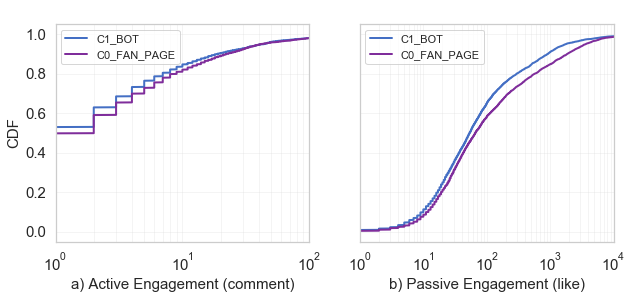

In [43]:
# total comment received
def plot_2():
    
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
    
    ALL_DF = [cluster_0, 
              cluster_1,
             ]
    
    ALL_Name = [
        'C1_BOT', 
              'C0_FAN_PAGE',
              
             ]
    
    # comment
    counter = 0
    for item in ALL_DF:
        if (item.shape[0] != 0):
                
            ser = pd.Series(reduce(operator.concat, item['comment'].tolist()))
            ser = ser.sort_values()
            ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser) 
            ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=axes[0], legend=True, label=ALL_Name[counter], c=vr.COLORS_CLUSTERS[counter])
            
        counter += 1

    ax.axes.set_xlim([1,100])
#     ax.axes.set_ylim([0.3,1.01])
    ax.set_ylabel("CDF")
    ax.set_xlabel("a) Active Engagement (comment)")
    ax.set_title(" ")
    ax.grid(True, which='both', linestyle='-', alpha=0.2)
    
    
    
    # like
    counter = 0
    for item in ALL_DF:
        if (item.shape[0] != 0):
                
            ser = pd.Series(reduce(operator.concat, item['like'].tolist()))
            ser = ser.sort_values()
            ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser) 
            ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=axes[1], legend=True, label=ALL_Name[counter], c=vr.COLORS_CLUSTERS[counter])
            
        counter += 1

    ax.axes.set_xlim([1,10000])
#     ax.axes.set_ylim([0.3,1.01])
#     ax.set_ylabel("CDF")
    ax.set_xlabel("b) Passive Engagement (like)")
    ax.set_title(" ")
    ax.grid(True, which='both', linestyle='-', alpha=0.2)
    
    
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)
    
    plt.savefig("plot_15Cluster_P2.pdf", bbox_inches='tight')
    
plot_2()

In [44]:
len(cluster_0['caption'].tolist()[0])

4

In [45]:
cluster_0.columns

Index(['user_id', 'avg comment', 'avg like', 'avg hashtag', 'avg caption len',
       'comment', 'like', 'caption', 'community', 'hashtag', '_id', 'username',
       'mediacount', 'followers', 'followees', 'biography', 'full_name',
       'is_verified', 'is_private', 'external_url', 'profile_pic_url',
       'profile_image', 'associated_hashtag', 'associated_username',
       'similarity_username', 'similarity_full_name', 'similarity_biography',
       'similarity_photo', 'post', 'story', 'highlight', 'relation_crawled',
       'followee_list', 'follower_list', 'external_url_value', 'lcm', 'mcm',
       'nfollower', 'nfollowee', 'nmediacount', 'nmcm', 'n avg comment',
       'n avg like', 'n avg hashtag', 'n avg caption len', 'cluster'],
      dtype='object')